In [35]:
!pip install yfinance


In [37]:
# Download example data
df = yf.download("^NSEI", start="2024-05-01", end="2025-05-01")
df = df.reset_index()
df['security'] = '^NSEI'
df = df.rename(columns={'Date': 'date', 'Open': 'open', 'Close': 'close'})

[*********************100%***********************]  1 of 1 completed


In [39]:
import yfinance as yf

nifty = yf.download("^NSEI", start="2024-06-01", end="2025-06-01")
print(nifty.head())  # Confirm the date is in index, not a column


[*********************100%***********************]  1 of 1 completed

Price              Close          High           Low          Open   Volume
Ticker             ^NSEI         ^NSEI         ^NSEI         ^NSEI    ^NSEI
Date                                                                       
2024-06-03  23263.900391  23338.699219  23062.300781  23337.900391   569400
2024-06-04  21884.500000  23179.500000  21281.449219  23179.500000  1006100
2024-06-05  22620.349609  22670.400391  21791.949219  22128.349609   638500
2024-06-06  22821.400391  22910.150391  22642.599609  22798.599609   480400
2024-06-07  23290.150391  23320.199219  22789.050781  22821.849609   473600


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Initial Resistance Breakout Backtest:
Empty DataFrame
Columns: []
Index: []
Total Return: 0.00%

Support/Resistance Levels:
          price  strength
0  24330.646146  0.001404
1  25020.808809  0.001265


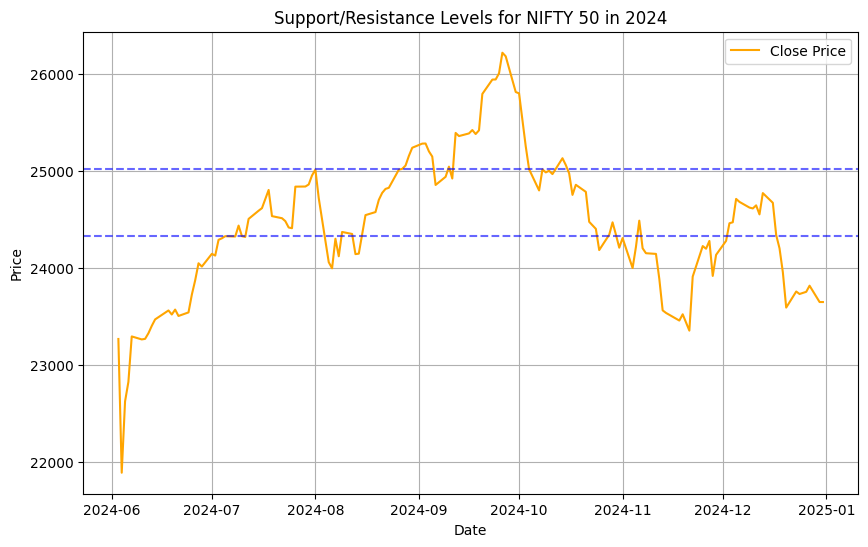


Final Backtest with refined KDE:
                                          entry_date  \
0  Ticker
   2024-07-09
Name: 25, dtype: datetime...   
1  Ticker
   2024-08-09
Name: 47, dtype: datetime...   
2  Ticker
   2024-10-14
Name: 91, dtype: datetime...   
3  Ticker
   2024-10-28
Name: 101, dtype: datetim...   
4  Ticker
   2024-11-06
Name: 108, dtype: datetim...   
5  Ticker
   2024-12-03
Name: 125, dtype: datetim...   

                                           exit_date   entry_price  \
0  Ticker
   2024-08-05
Name: 43, dtype: datetime...  24433.199219   
1  Ticker
   2024-10-07
Name: 86, dtype: datetime...  24367.500000   
2  Ticker
   2024-10-17
Name: 94, dtype: datetime...  25127.949219   
3  Ticker
   2024-11-04
Name: 106, dtype: datetim...  24339.150391   
4  Ticker
   2024-11-13
Name: 113, dtype: datetim...  24484.050781   
5  Ticker
   2024-12-19
Name: 137, dtype: datetim...  24457.150391   

     exit_price    return  
0  24055.599609 -1.545437  
1  24795.750000  1.757464 

In [60]:
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Download data
df = yf.download("^NSEI", start="2024-05-01", end="2025-05-01")
df = df.reset_index()
df['security'] = '^NSEI'
df = df.rename(columns={'Date': 'date', 'Open': 'open', 'Close': 'close'})

class SupportResistance:
    def __init__(self, stock, year):
        self.stock = stock
        self.year = year
        self.data = None
        self.estimator = None
        self.pdf = None
        self.xx_ = None
        self.support_resistances = None
        self.strengths = None

    def get_data(self, file):
        file = file.copy()
        file.reset_index(inplace=True)
        file['date'] = pd.to_datetime(file['Date'])
        file['year'] = file['date'].dt.year

        data = file[file['year'] == self.year]

        if not all(col in data.columns for col in ['Open', 'Close', 'Low']):
            raise ValueError("Columns 'Open', 'Close', 'Low' not found in input data.")

        data = data[['date', 'Open', 'Close', 'Low']]
        data.rename(columns={'Open': 'open', 'Close': 'close', 'Low': 'low'}, inplace=True)

        prices = np.vstack([data['open'], data['close']]).reshape(-1, 1)

        self.data = data
        self.prices = prices

    def fit(self, min_bandwidth_log=-1, max_bandwidth_log=1, n_bandwidths=100, min_prominence=0.01):
        bandwidths = 10 ** np.linspace(min_bandwidth_log, max_bandwidth_log, n_bandwidths)
        grid = GridSearchCV(KernelDensity(), {'kernel': ['gaussian'], 'bandwidth': bandwidths})
        grid.fit(self.prices)
        best_estimator = grid.best_estimator_
        kde = best_estimator.fit(self.prices)
        a, b = min(self.prices)[0], max(self.prices)[0]
        xx = np.linspace(a, b, 1000).reshape(-1, 1)
        pdf = np.exp(kde.score_samples(xx))
        peaks, _ = find_peaks(pdf, prominence=min_prominence)
        self.support_resistances = xx[peaks]
        self.strengths = pdf[peaks]
        self.estimator = best_estimator
        self.xx_ = xx
        self.pdf = pdf

    def data_frame(self):
        if self.support_resistances is None:
            raise ValueError("Fit not performed. Call fit() first.")
        return pd.DataFrame({'price': self.support_resistances.reshape(-1,), 'strength': self.strengths.reshape(-1,)})

    def plot_price(self, figsize=(10, 6)):
        plt.figure(figsize=figsize)
        plt.title(f'Support/Resistance Levels for {self.stock} in {self.year}')
        plt.plot(self.data['date'], self.data['close'], color='orange', label='Close Price')
        for level in self.support_resistances:
            plt.axhline(y=level, linestyle='--', color='blue', alpha=0.6)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

# Load latest data
nifty = yf.download("^NSEI", start="2024-06-01", end="2025-06-01")

# Backtest with trailing stop-loss
def backtest_with_trailing_stop(sr):
    df = sr.data.copy()
    resistance_levels = sr.data_frame()['price'].tolist()
    trades = []
    in_trade = False
    entry_price, stop_loss = 0, 0

    for i in range(1, len(df)):
        price = float(df.iloc[i]['close'].item())
        prev_close = float(df.iloc[i - 1]['close'].item())
        prev_low = float(df.iloc[i - 1]['low'].item())
        date = df.iloc[i]['date']

        if not in_trade:
            for r in resistance_levels:
                if prev_close <= r < price:
                    entry_price = price
                    stop_loss = prev_low  # ✅ Correct: initial stop loss = low of previous day
                    entry_date = date
                    in_trade = True
                    break
        else:
            if price >= entry_price * 1.05:
                stop_loss = max(stop_loss, price * 0.95)
            if price <= stop_loss:
                trades.append({
                    'entry_date': entry_date,
                    'exit_date': date,
                    'entry_price': entry_price,
                    'exit_price': price
                })
                in_trade = False

    trades_df = pd.DataFrame(trades)

    if len(trades_df) > 0:
        trades_df['return'] = (trades_df['exit_price'] - trades_df['entry_price']) / trades_df['entry_price'] * 100
        total_return = trades_df['return'].sum()
    else:
        total_return = 0

    return trades_df, total_return

# Run analysis
sr = SupportResistance('NIFTY 50', 2024)
sr.get_data(file=nifty)
sr.fit(min_bandwidth_log=-2, max_bandwidth_log=1, n_bandwidths=1000, min_prominence=0.01)

trades_df, total_return = backtest_with_trailing_stop(sr)
print("Initial Resistance Breakout Backtest:")
print(trades_df)
print(f"Total Return: {total_return:.2f}%")

# Optional refinement
sr.fit(min_bandwidth_log=-2, max_bandwidth_log=1, n_bandwidths=500, min_prominence=0.001)
print("\nSupport/Resistance Levels:")
print(sr.data_frame())

sr.plot_price()

trades_df, total_return = backtest_with_trailing_stop(sr)
print("\nFinal Backtest with refined KDE:")
print(trades_df)
print(f"Total Return: {total_return:.2f}%")
